### Задача uplift-моделирования

Используем набор данных маркетинговых кампаний https://www.kaggle.com/davinwijaya/customer-retention

In [145]:
#!pip install scikit-uplift catboost

In [152]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

In [153]:
df = pd.read_csv('data.csv')

In [154]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [155]:
df.rename(columns = {'offer':'treatment','conversion': 'target'}, inplace = True)

In [156]:
df['treatment'].value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: treatment, dtype: int64

In [157]:
df.loc[df['treatment'] == 'No Offer', 'treatment'] = 0

In [158]:
df.loc[df['treatment'] !=0, 'treatment'] = 1

In [159]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0


In [160]:
df['treatment'].value_counts()

1    42694
0    21306
Name: treatment, dtype: int64

In [161]:
cat_features =['zip_code', 'channel']

In [162]:
X_train, X_val, y_train, y_val = train_test_split(df.drop('target', 1), df['target'], test_size = 0.25, random_state = 100)

In [163]:
treat_train = X_train['treatment']
X_train = X_train.drop('treatment', 1)
treat_val = X_val['treatment']
X_val = X_val.drop('treatment', 1)

## 1. Подходы с одной моделью

In [164]:
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

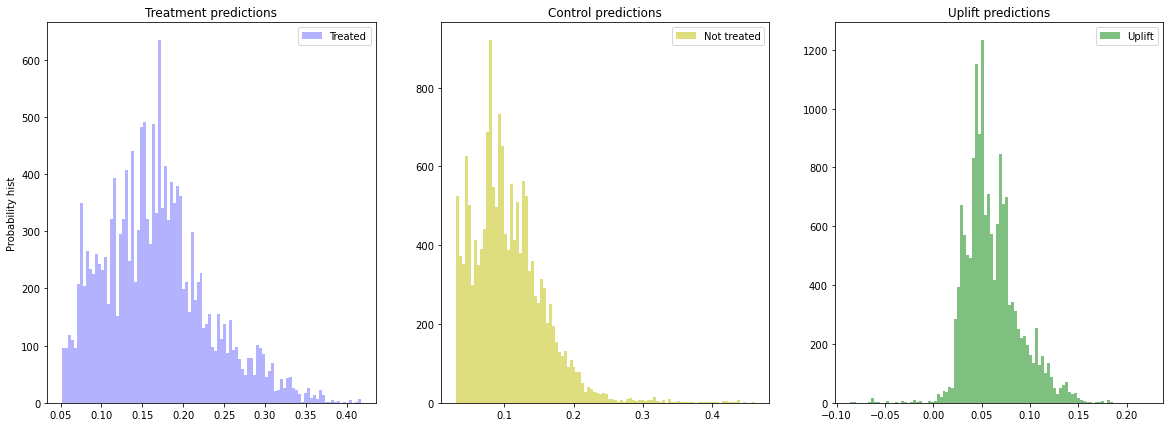

In [165]:
# Ссылка на документацию: https://scikit-uplift.readthedocs.io/en/latest/
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier


sm = SoloModel(
    CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_features)
)

sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_val)

sm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

Посмотрим на топ-признаки

In [166]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,is_referral,20.379718
1,treatment,18.818739
2,used_bogo,13.506511
3,zip_code,11.514287
4,history,10.514233
5,used_discount,9.731791
6,recency,9.197640
7,channel,6.337081


In [167]:
sm_score_10

0.1036544850498339

In [168]:
sm_score_20

0.07763012181616835

In [169]:
from sklift.models import ClassTransformation


ct = ClassTransformation(
    CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_features)
)
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_val)

ct_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)

In [170]:
ct_score_10

0.0899667774086379

In [171]:
ct_score_20

0.08110741971207086

### 2. Две независимые модели
Как понятно из названия, подход заключается в моделировании условных вероятностей тестовой и контрольной групп отдельно. В статьях утверждается, что такой подход достаточно слабый, так как обе модели фокусируются на прогнозировании результата отдельно и поэтому могут пропустить "более слабые" различия в выборках.

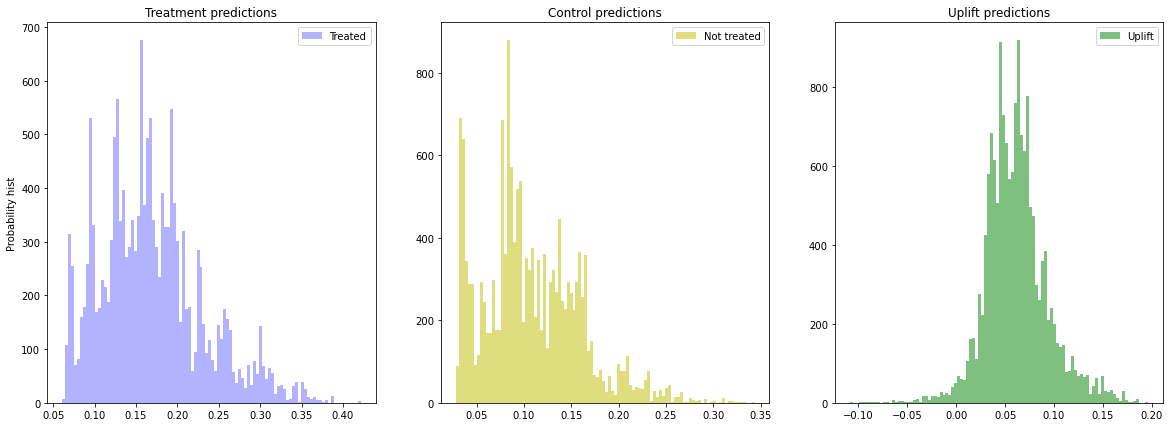

In [172]:
from sklift.models import TwoModels


tm = TwoModels(
    CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_features),
    CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_features),
    method='vanilla'  # независимые модели
)
tm = tm.fit(
    X_train, y_train, treat_train
)

uplift_tm = tm.predict(X_val)

tm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

Посмотрим на результаты трех моделей для 10% и 20%

In [175]:
pd.DataFrame(data=models_results)

,approach,uplift@10%,uplift@20%
0,SoloModel,0.103654,0.077630
1,ClassTransformation,0.089967,0.081107
2,TwoModels,0.075393,0.077586


Вывод: class transformation и solo дают нам результат лучше, чем two models. При этом solo показывает на 10% результат выше, чем на 20%. На 10% uplift самый высокий из всех показателей.

Solo Model


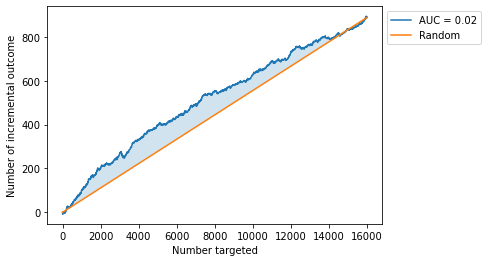

ClassTransform Model


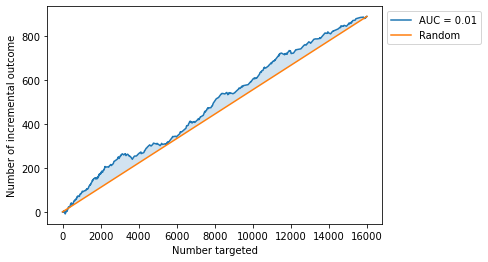

Two Model


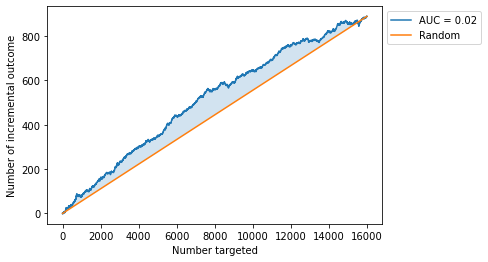

In [176]:
import matplotlib.pyplot as plt

print('Solo Model')
plot_uplift_curve(y_val, uplift_sm, treat_val, perfect=False)
plt.show()
print('ClassTransform Model')
plot_uplift_curve(y_val, uplift_ct, treat_val, perfect=False)
plt.show()
print('Two Model')
plot_uplift_curve(y_val, uplift_tm, treat_val, perfect=False)
plt.show()

6. *для модели S-learner построить зависимость таргета (конверсии - поле conversion) от значения uplift:
    1. сделать прогноз и получить uplift для тестовой выборки
    2. отсортировать тестовую выборку по uplift по убыванию
    3. разбить на децили (pandas qcut вам в помощь)
    4. для каждого дециля посчитать среднюю conversion

In [207]:
sm = SoloModel(
    CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_features)
)

sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_val)

df_val_target_uplift = pd.DataFrame(data = {'target': y_val, 'uplift': uplift_sm}).sort_values(by ='uplift', ascending=False)
df_val_target_uplift

,target,uplift
50292,1,0.222628
4559,1,0.215867
22367,0,0.205222
15197,0,0.195267
55954,0,0.193017
...,...,...
17439,1,-0.082123
50201,1,-0.082608
1039,0,-0.083117
13802,0,-0.083277


In [208]:
df_val_target_uplift['deciles'] = pd.qcut(df_val_target_uplift['uplift'], 10)
df_val_target_uplift

,target,uplift,deciles
50292,1,0.222628,"(0.0989, 0.223]"
4559,1,0.215867,"(0.0989, 0.223]"
22367,0,0.205222,"(0.0989, 0.223]"
15197,0,0.195267,"(0.0989, 0.223]"
55954,0,0.193017,"(0.0989, 0.223]"
...,...,...,...
17439,1,-0.082123,"(-0.0872, 0.0311]"
50201,1,-0.082608,"(-0.0872, 0.0311]"
1039,0,-0.083117,"(-0.0872, 0.0311]"
13802,0,-0.083277,"(-0.0872, 0.0311]"


In [221]:
deciles_mean_target = df_val_target_uplift.drop('uplift', axis = 1).groupby(by = 'deciles').mean()
deciles_mean_target

,target
deciles,
"(-0.0872, 0.0311]",0.109530
"(0.0311, 0.0404]",0.105263
"(0.0404, 0.0456]",0.126019
"(0.0456, 0.0506]",0.123810
"(0.0506, 0.0559]",0.132583
"(0.0559, 0.0642]",0.135625
"(0.0642, 0.0717]",0.141875
"(0.0717, 0.08]",0.165000
"(0.08, 0.0989]",0.176544


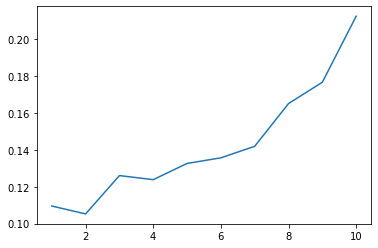

In [219]:
plt.plot(range(1, 11), deciles_mean_target['target'])

Вывод: чем выше значение uplift в интервале - дециле (децили сформированы после сортировки по uplift), тем как правило выше среднее значение целевой переменной в этом интервале. Дециль с максимальными значениями uplift (0.0989-0.223) имеет самое высокое среднее значение conversion.